<a href="https://colab.research.google.com/github/iamNirmeshGupta/Credit-Card-Default-Prediction/blob/main/Credit_Card_Default_Prediction_Nirmesh_Gupta_Individual_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xlrd==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 6.0 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


##**This project is aimed at predicting the case of customers' default payment in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - Credible or not Credible clients.**

In [2]:
# Importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn import metrics  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier


import warnings
warnings.simplefilter("ignore")
from pprint import pprint
import joblib
import imblearn

In [3]:
# Importing the dataset

df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/alma better/Credit Card Default prediction - Capstone Project - Classification/Copy of default of credit card clients.xls")

In [4]:
# Basic Inspection

df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [17]:
# Removing the unnamed row and setting row 0 as column header

df1 = df.rename(columns=df.iloc[0]).loc[1:]
df1.reset_index(inplace=True)
df1.drop(['index'],inplace=True,axis = 1)

In [19]:
# Basic Inspection

df1.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [20]:
# Checking the shape of the data

df1.shape

(30000, 25)

##**Understanding the Data**

###**Data Description**

###**There are 25 variables:**
**• ID**: ID of each client. \
**• LIMIT_BAL:** Amount of given credit in NT dollars (includes individual and family/supplementary credit. \
**• SEX:** Gender (1=male, 2=female) \
**• EDUCATION:** (1=graduate school, 2=university, 3=high school, 4=others) \
**• MARRIAGE:** Marital status (1=married, 2=single, 3=others) \
**• AGE:** Age in years \
**• PAY_0:** Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above) \
**• PAY_2:** Repayment status in August, 2005 (scale same as above) \
**• PAY_3:** Repayment status in July, 2005 (scale same as above) \
**• PAY_4:** Repayment status in June, 2005 (scale same as above) \
**• PAY_5:** Repayment status in May, 2005 (scale same as above) \
**• PAY_6:** Repayment status in April, 2005 (scale same as above) \
**• BILL_AMT1:** Amount of bill statement in September, 2005 (NT dollar) \
**• BILL_AMT2:** Amount of bill statement in August, 2005 (NT dollar) \
**• BILL_AMT3:** Amount of bill statement in July, 2005 (NT dollar) \
**• BILL_AMT4:** Amount of bill statement in June, 2005 (NT dollar) \
**•BILL_AMT5**: Amount of bill statement in May, 2005 (NT dollar) \
**• BILL_AMT6:** Amount of bill statement in April, 2005 (NT dollar) \
**• PAY_AMT1:** Amount of previous payment in September, 2005 (NT dollar) \
**• PAY_AMT2:** Amount of previous payment in August, 2005 (NT dollar) \
**• PAY_AMT3:** Amount of previous payment in July, 2005 (NT dollar) \
**• PAY_AMT4:** Amount of previous payment in June, 2005 (NT dollar) \
**• PAY_AMT5:** Amount of previous payment in May, 2005 (NT dollar) \
**• PAY_AMT6:** Amount of previous payment in April, 2005 (NT dollar) \
**• default.payment.next.month:** Default payment (1=yes, 0=no)

In [21]:
# Printing all the columns in the data

df1.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [24]:
# Checking basic data info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  object
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  object
 4   MARRIAGE                    30000 non-null  object
 5   AGE                         30000 non-null  object
 6   PAY_0                       30000 non-null  object
 7   PAY_2                       30000 non-null  object
 8   PAY_3                       30000 non-null  object
 9   PAY_4                       30000 non-null  object
 10  PAY_5                       30000 non-null  object
 11  PAY_6                       30000 non-null  object
 12  BILL_AMT1                   30000 non-null  object
 13  BILL_AMT2                   30000 non-null  ob

In [23]:
# Checking the pay column
df1['PAY_0'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64

###**What do 0 and -2 mean in PAY_X columns?**
From dataset documentation: PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above).We notice that code 0 and -2 are in the PAY_X columns by checking the value counts but are not included in the data description. Also by doing the value_counts, it shows 0 is the most frequent observation.

After searching online, I found:

-2: No consumption;
-1: Paid in full;
0: The use of revolving credit, meaning the payment wasn't due, which makes sense that most customers were using the revolving credit.

## **Data Cleaning**

###**Checking null values**

In [31]:
# Checking is any of the columns contain any null values
df1.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

###**As we can see there are no null values in our dataset, which is good.**

###**Checking duplicate rows**

In [32]:
# Checking if the dataset contains any duplicate rows
df1.duplicated().any()

False

**There no duplicate records in our dataset either.**

In [34]:
#Checking entries of the "ID" column
df1['ID'].value_counts()

1        1
19997    1
20009    1
20008    1
20007    1
        ..
9996     1
9995     1
9994     1
9993     1
30000    1
Name: ID, Length: 30000, dtype: int64

**The 'ID' entries are unique for every row and seem to serve the purpose of a serial number. I will drop that variable**

In [36]:
# Dropping 'ID' column
df1.drop(['ID'],inplace=True,axis=1) 

###**Checking data types of the features**

In [37]:
# Using dataset info to check the data types
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LIMIT_BAL                   30000 non-null  object
 1   SEX                         30000 non-null  object
 2   EDUCATION                   30000 non-null  object
 3   MARRIAGE                    30000 non-null  object
 4   AGE                         30000 non-null  object
 5   PAY_0                       30000 non-null  object
 6   PAY_2                       30000 non-null  object
 7   PAY_3                       30000 non-null  object
 8   PAY_4                       30000 non-null  object
 9   PAY_5                       30000 non-null  object
 10  PAY_6                       30000 non-null  object
 11  BILL_AMT1                   30000 non-null  object
 12  BILL_AMT2                   30000 non-null  object
 13  BILL_AMT3                   30000 non-null  ob

###As we can see, the data type of all the columns is 'object' type. So let's convert their data type to integer.

In [40]:
# Converting the data type of the features
df1 = df1.astype('int')

In [41]:
#Checking the dataset info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

###**Changing Column Names**

In [43]:
# Simplifying column names and bringing consistency
df1.rename(columns={"PAY_0":"PAY_1","default payment next month":"DEFAULT"},inplace=True)

df1.columns = [name.lower() for name in list(df1.columns)]

In [46]:
# Getting statistical summary of the dataset
df1.describe(include="all").transpose()

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
sex,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
education,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
marriage,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
age,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
pay_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
pay_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
pay_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
pay_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
pay_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


**As we can see, marriage has a minimum value of 0 but the description said the minimum value is 1. And education has a maximum value of 6 while it was supposed to have a maximum value of 4 according to the data description.And we can also see that no data is extremely unreasonable in terms of values.**

##**Checking Categorical Columns**

**Here, we will check these 3 columns: "sex", "education" and "marriage"**

###Sex Column

In [47]:
# Checking sex column
df1['sex'].value_counts()

2    18112
1    11888
Name: sex, dtype: int64

The sex column looks fine and there is no undocumented data.

###Education Column

In [48]:
# Checking "education" column
df1['education'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: education, dtype: int64

Here we notice 5 and 6 are both recorded as 'unknown' and there are values like 0,5 and 6 which are not explained in the dataset description. Since the amounts are so small, let's combine 0,4,5,6 to 0 which means"other.

In [50]:
# Change values 4, 5, 6 to 0 and define 0 as 'others'
# 1=graduate school, 2=university, 3=high school, 0=others

df1["education"] = df1["education"].replace({4:0,5:0,6:0})
df1["education"].value_counts()

2    14030
1    10585
3     4917
0      468
Name: education, dtype: int64

###Marriage Column

In [51]:
# Checking "marriage" column
df1['marriage'].value_counts()

2    15964
1    13659
3      323
0       54
Name: marriage, dtype: int64

As we can see, there is a value of 0 as well in the "marriage" column, which is not described in the dataset description. \
What does 0 mean in 'MARRIAGE'? Since there are only 0.18% (or 54) observations of 0, we will combine 0 and 3 in one value as 'others'

In [52]:
# Combine 0 and 3 by changing the value 0 into 3

df1["marriage"] = df1["marriage"].replace({0:3})
df1["marriage"].value_counts()

2    15964
1    13659
3      377
Name: marriage, dtype: int64

##**Exploratory Data Analysis**

Let's first start with our target variable.

###**Checking frequency of defaulters and non defaulters**

Text(0.5, 1.0, 'Distribution of defaulters vs non-defaulters')

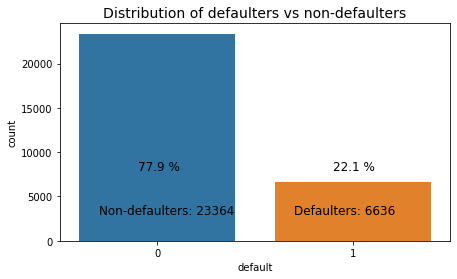

In [53]:
# Checking frequency of defaulters

defs = df1["default"].sum()
non_defs = len(df1) - defs

# Percentage
def_perc = round(defs / len(df1) * 100, 1)
non_def_perc = round(non_defs / len(df1) * 100, 1)

# import sys
plt.figure(figsize=(7, 4))
# sns.set_context('notebook', font_scale=1.2)
sns.countplot("default", data=df1)  # ,palette="Blues"
plt.annotate(
    "Non-defaulters: {}".format(non_defs),
    xy=(-0.3, 15000),
    xytext=(-0.3, 3000),
    size=12,
)
plt.annotate(
    "Defaulters: {}".format(defs), xy=(0.7, 15000), xytext=(0.7, 3000), size=12
)
plt.annotate(str(non_def_perc) + " %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
plt.annotate(str(def_perc) + " %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
plt.title("Distribution of defaulters vs non-defaulters", size=14)

We can see, almost 78% of all the observations are of non-defaulters and almost 22% are of defaulters.
Also, there is class imbalance in our target feature which I will deal with later.

##**Relationship Between the Variables and Default**

Here, I will study the relationship between the features and credit card default.

In [61]:
def compare_default_across_features(df, col_name, dict_label={}):
  """
  This function quantifies and displays the distribution of default across the various classes of a feature.
  """

  #Create a cross-tab and rename indices for readability

  cross_tab = pd.crosstab(df["default"], df[col_name], margins=True, normalize=False)

  new_index = {0: "Non-default proportion", 1: "Default proportion"}
  new_columns = dict_label

  cross_tab.rename(index=new_index, columns=new_columns, inplace=True)

  # Plot a bar graph showing population distribution by the feature values

  plt.figure(figsize=(10,5))
  i = cross_tab.shape[1] - 1
  cross_tab.loc["All"][0:i].plot.bar(rot=30, fontsize=14)
  plt.title("Population distribution by " + col_name, fontsize=20)
  plt.ylabel("Count")
  plt.show()
  
  # Normalize the cross-tab and print it
  cross_tab_norm = cross_tab/cross_tab.loc["All"]
  display(cross_tab_norm)

  # Plot a bar graph showing population distribution by the feature values separating the defaulters and no defaulters
  plt.figure(figsize=(10,5))
  ax = sns.countplot(x=col_name, hue="defaut", data=df)
  plt.title("Population distribution by " + col_name + " with default and no-default", fontsize=20,)

  # Return the normalized cross-tab
  return cross_tab_norm

